## Behavioral Cloning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from keras.preprocessing import image as kimage
from keras.models import model_from_json
from model import preprocess
%matplotlib inline

Using TensorFlow backend.


In [2]:
data_dir = 'data_sdc'
driving_log = pd.read_csv(data_dir + '/driving_log.csv', usecols=[0, 1, 2, 3])

In [3]:
driving_log.head()

,center,left,right,steering
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0


In [4]:
driving_log.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
steering,8036.0,0.00407,0.12884,-0.942695,0.0,0.0,0.0,1.0


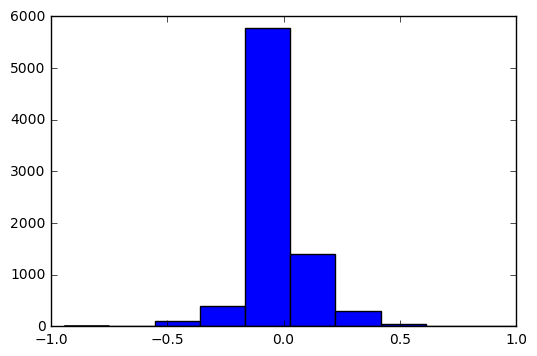

In [5]:
plt.hist(driving_log['steering'], bins = 10);

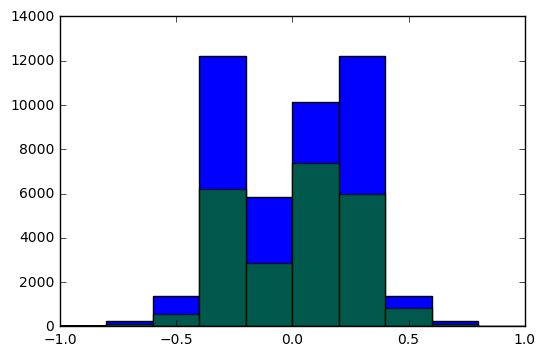

In [6]:
center_steering = driving_log['steering']
right_steering = driving_log['steering'] - 0.25
left_steering = driving_log['steering'] + 0.25
all_steering = pd.concat([center_steering, right_steering, left_steering])

flipped_steering = all_steering[abs(all_steering)>0.01] * -1

plt.hist(pd.concat([all_steering, flipped_steering]), bins=np.arange(-1, 1 + 0.2, 0.2));
plt.hist(all_steering, alpha=0.7, bins=np.arange(-1, 1 + 0.2, 0.2));

In [7]:
print("Total:", len(driving_log['steering']))
print("Flipped:", len(driving_log[abs(driving_log['steering'])>0.01]))

Total: 8036
Flipped: 3584


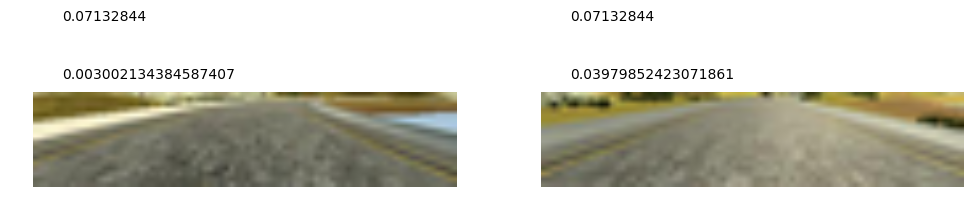

In [8]:
# Load model
with open("model.json", 'r') as jfile:
    model = model_from_json(jfile.read())
model.compile("adam", "mse")
model.load_weights("model.h5")

# Plot sample images
n_samples = 2
indexes = np.random.randint(0, len(driving_log), n_samples)
fig, axs = plt.subplots(1, n_samples)
fig.set_size_inches(12, 4)

for i,index in enumerate(indexes):
    axs[i].axis('off')
    axs[i].text(5,-14, driving_log.ix[index]['steering'])
    image = kimage.load_img(data_dir + "/" + driving_log.ix[index]['center'].strip())
    image_array = preprocess(image, normalize=False)
    
    processed_image = preprocess(image)
    predicted_steering = float(model.predict(processed_image[None, :, :, :], batch_size=1))
    axs[i].text(5, -3, predicted_steering)
    axs[i].imshow(image_array)